<a href="https://colab.research.google.com/github/MeghnaDixit38/BTP/blob/main/GR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
import torch 

In [ ]:
pi = np.pi
from torch.utils.data import Dataset, DataLoader

Solving the PDE: \\
$$-u''(x) = f(x)$$
Given: $$u(x=0) = const$$


In [ ]:
def u(x):
  return np.cos(2*pi*x)

$$ u(x) = \cos(2\pi x)$$
$$ f(x) = 4\pi^2 \cos(2\pi x) $$

In [ ]:
x0 = 0.0
xf = 1.0
dx = 0.01
nx = int((xf - x0)/dx)

u0 = 2*pi
xs = np.linspace(x0, xf, (nx + 1))

In [ ]:
class data(Dataset):
  def __init__(self, ts):
    self.ts = torch.tensor(ts, dtype=torch.float32).unsqueeze(1)

  def __len__(self):
    return len(self.ts)

  def __getitem__(self, idx):
    t = self.ts[idx]
    return t

class Net(torch.nn.Module):
  def __init__(self, n_hidden):
    super(Net, self).__init__()
    self.n_hidden = n_hidden
    self.layer1 = torch.nn.Linear(1, n_hidden)
    self.layer2 = torch.nn.Linear(n_hidden, n_hidden)
    self.layer3 = torch.nn.Linear(n_hidden, n_hidden)
    self.layer4 = torch.nn.Linear(n_hidden, n_hidden)
    self.layer5 = torch.nn.Linear(n_hidden, n_hidden)
    self.layer6 = torch.nn.Linear(n_hidden, 1)

  def forward(self, ts):
    x = self.layer1(ts)
    x = torch.tanh_(x)
    x = self.layer2(x)
    x = torch.tanh(x)
    x = self.layer3(x)
    x = torch.tanh(x)
    x = self.layer4(x)
    x = torch.tanh(x)
    x = self.layer5(x)
    x = torch.tanh(x)
    x = self.layer6(x)
    return x

In [ ]:
def _function(x, u, utt):
  # return utt - 2*pi*torch.cos(2*pi*x)
  return utt + 4*pi*pi*torch.cos(2*pi*x)

def loss_model(model, xb, h, x0, u0, x1, u1, w0, wt):
  ub = model(xb)
  # ubt = torch.autograd.grad(ub,xb)
  # ubtt = torch.autograd.grad(ubt, xb)
  ubt = (model(xb+h) - ub)/h
  ubt_1 = (model(xb+2*h) - model(xb+h))/h
  ubtt = (ubt_1 - ubt)/h 
  ode = _function(xb, ub, ubtt)
  res_int = torch.mean(ode**2)
  res_bdy = (model(torch.tensor([x0], dtype=torch.float32)) - u0)**2
  res_bdy2 = (model(torch.tensor([x1], dtype=torch.float32)) - u1)**2
  res = res_int + w0*res_bdy + wt*res_bdy2
  return res

In [ ]:
def train(model, optimizer, dl, h=1e-3, x0=0.0, u0= 1.0, x1=1.0 , u1= 1.0 , w0=1.0 , wt=1.0):
  train_loss = 0.0
  loss= 0.0
  for xb in dl:
    optimizer.zero_grad()
    loss = loss_model(model, xb, h, x0, u0,x1, u1, w0,  wt)
    loss.backward()
    optimizer.step()
    train_loss += loss.item()
  train_loss /= len(dl)
  return train_loss

Epoch 0/900: loss = 846.6729736328125
Epoch 100/900: loss = 0.5305638611316681
Epoch 200/900: loss = 0.4288540184497833
Epoch 300/900: loss = 6.086397647857666
Epoch 400/900: loss = 0.4760701656341553
Epoch 500/900: loss = 1.1136806309223175
Epoch 600/900: loss = 1.3024661540985107
Epoch 700/900: loss = 4.42523717880249
Epoch 800/900: loss = 0.190480537712574


Text(0, 0.5, 'Training loss')

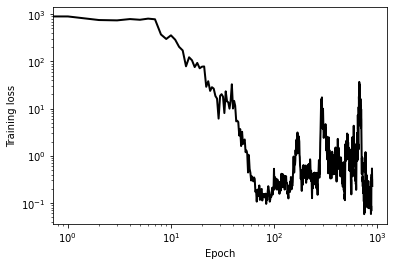

In [ ]:
data_ode = data(xs)
batch = 85
dl_ode = DataLoader(data_ode, batch_size=batch, shuffle=True)

n_hid = 600
dnn_ode = Net(n_hidden=n_hid)

epochs = 900
lr = 1e-3
eps = 1e-7
optimizer = torch.optim.Adam(dnn_ode.parameters(),lr=lr, eps=eps)

# SGD(dnn_ode.parameters(), lr=lr)

losses = []
for epoch in range(epochs):
  loss = train(dnn_ode, optimizer, dl_ode, w0 =10.0, wt=10.0)
  losses.append(loss)
  if epoch%100 == 0:
    print(f'Epoch {epoch}/{epochs}: loss = {loss}')

plt.loglog(losses, 'k-', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Training loss')

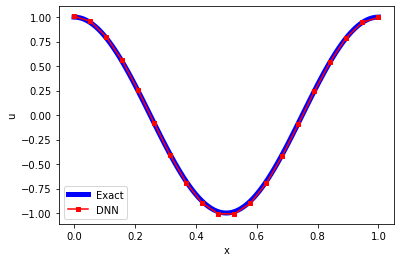

In [ ]:
n_test = 20
xs_test = np.linspace(x0, xf, n_test)
xp = torch.tensor(xs_test, dtype=torch.float32).unsqueeze(1)
us_dnn = dnn_ode(xp)
up = us_dnn.squeeze().detach().cpu().numpy()
us_exact = u(xs)
plt.plot(xs, us_exact, 'b-', linewidth=5, label='Exact')
# plt.plot(xs, us, 'bo', markersize=4, label='FD')
plt.plot(xp, up, 'rs-', markersize=4, label='DNN')
plt.xlabel('x')
plt.ylabel('u')
plt.legend()